In [1]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from scipy.stats import norm

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.simplefilter("ignore", FutureWarning)  # ignore some seaborn warnings until they update numpy

In [2]:
df = pandas.read_csv("NHL_API_point_totals_by_team_season_raw_1996-2003.csv")
sea_df = df[df["team"] == "SEA"].copy()
sea_df

,team,season_end,total_points,points_rank
798,SEA,2022,60,30
830,SEA,2023,100,12


In [3]:
df = df[df["team"] != "SEA"].copy().sort_values(by=["team", "season_end"])

<Axes: xlabel='total_points', ylabel='Count'>

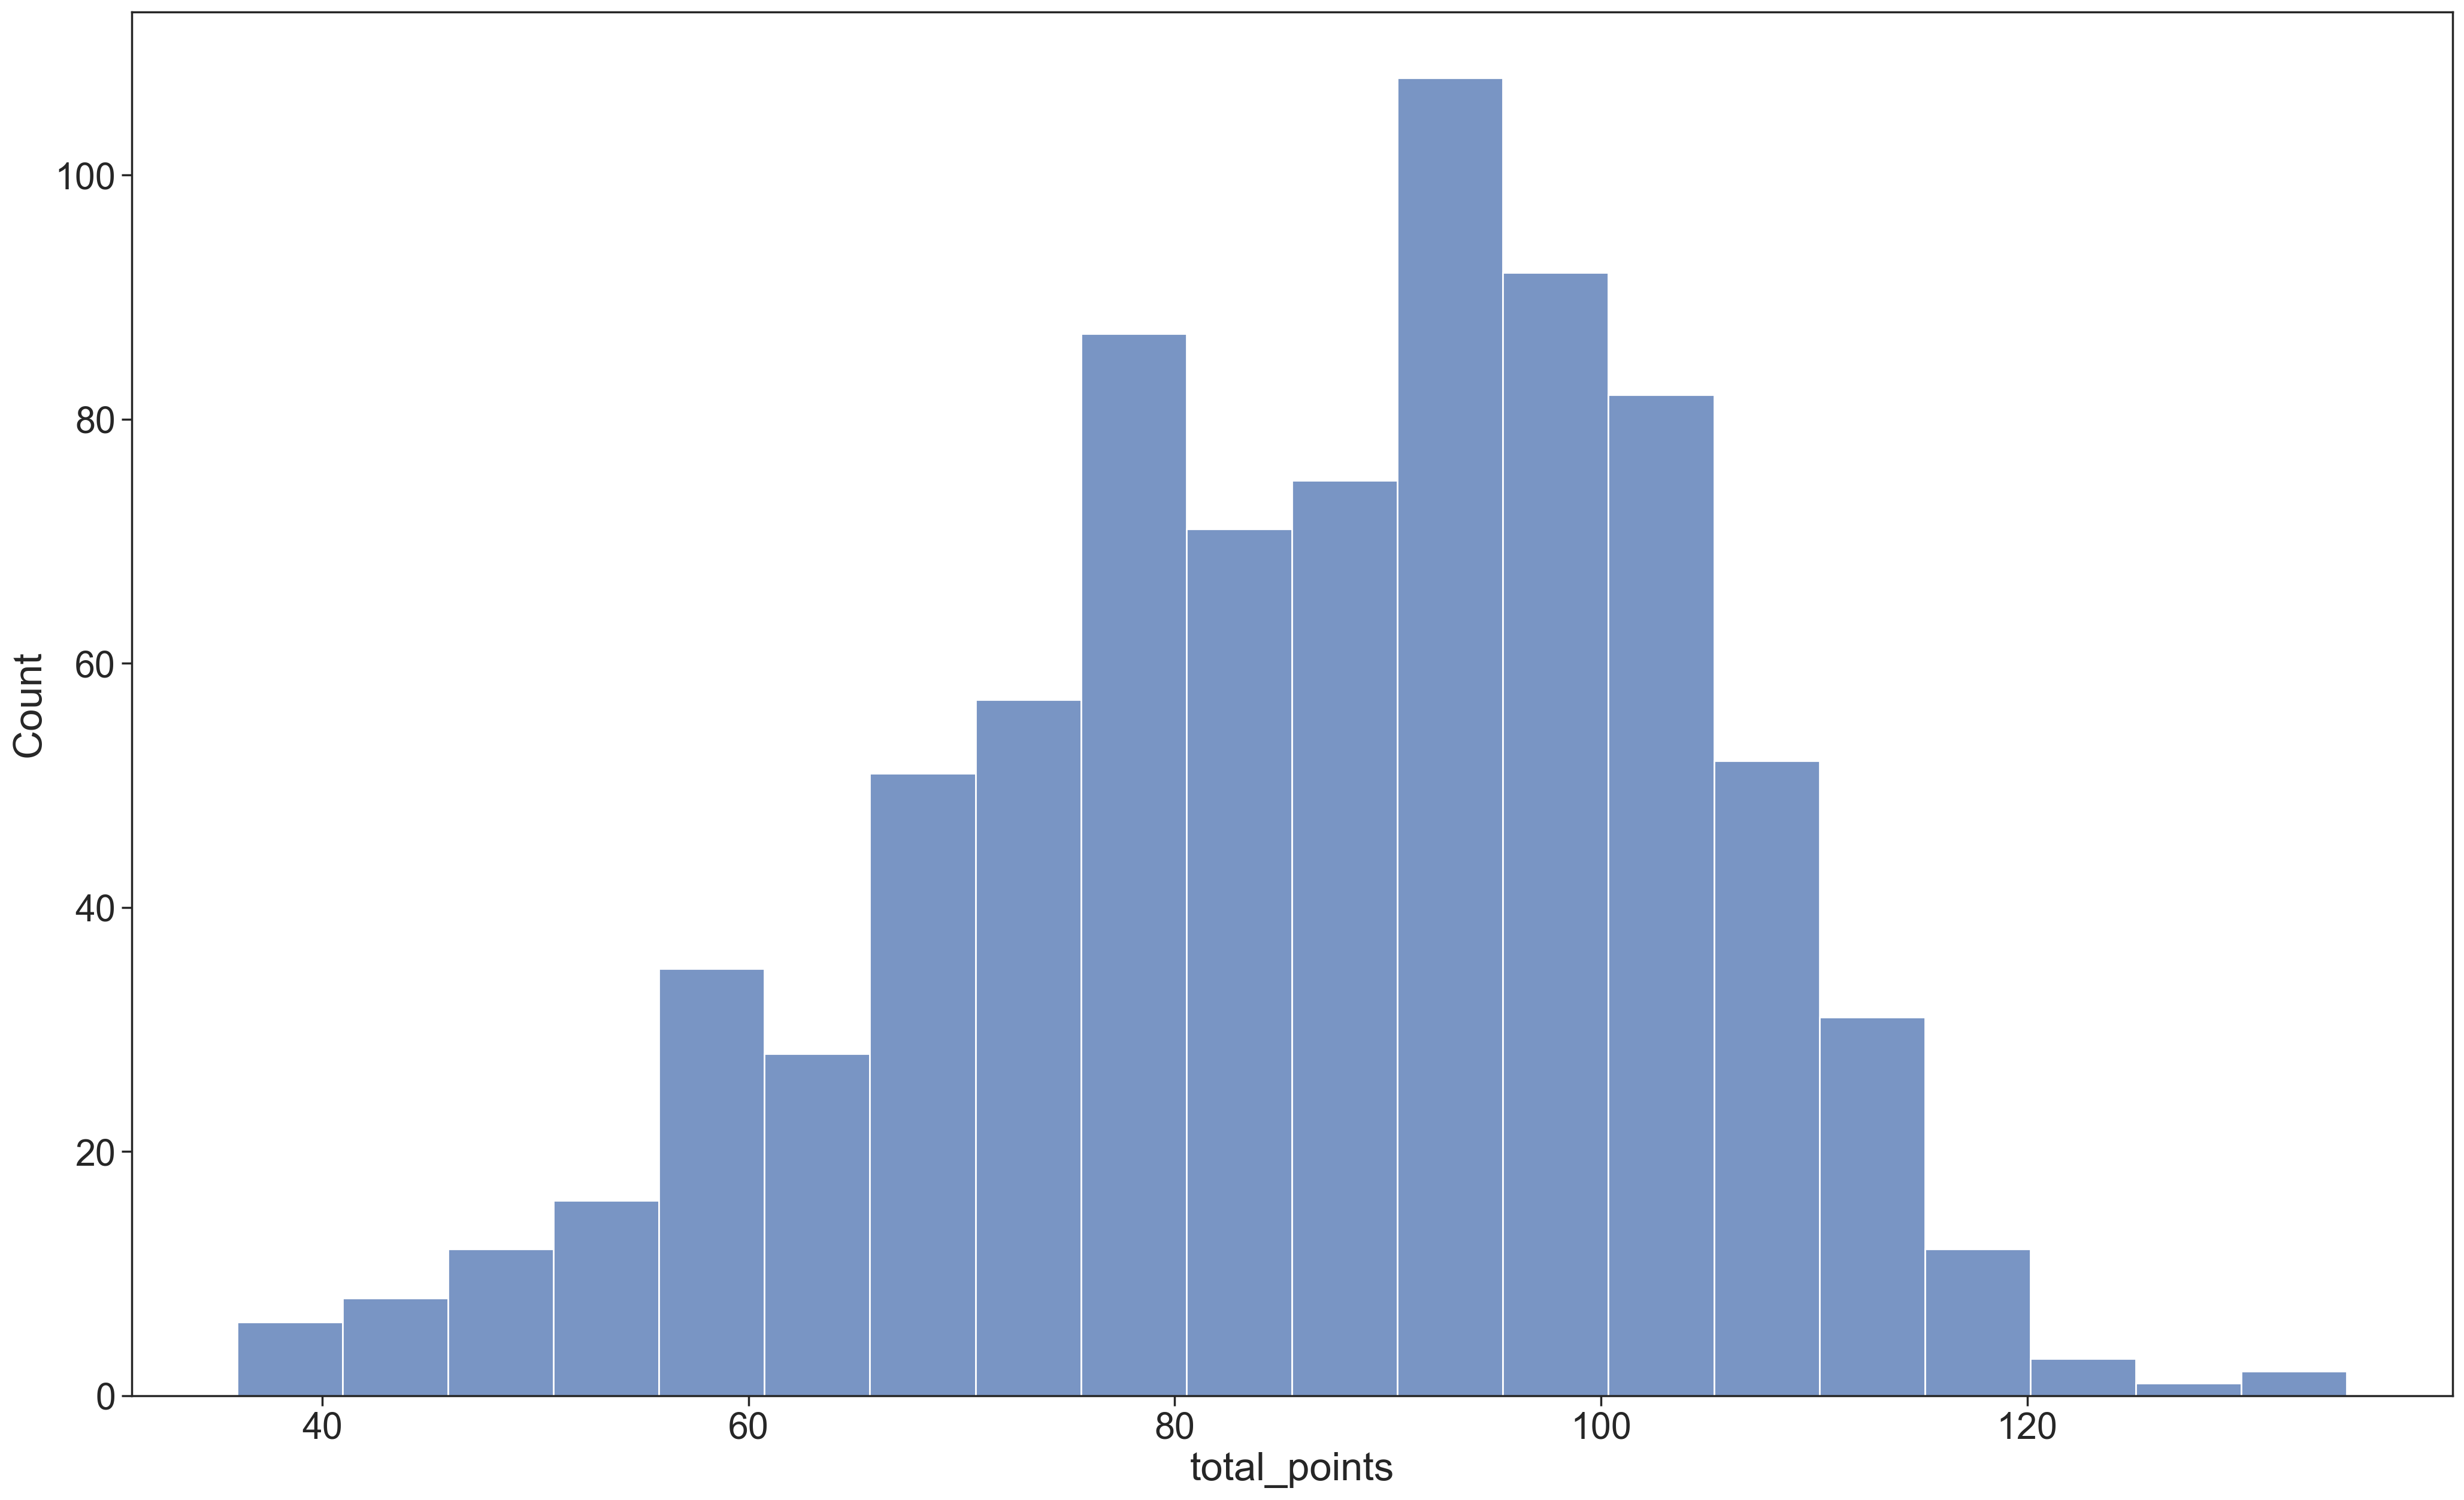

In [4]:
sns.histplot(x=df["total_points"])

In [17]:
total_points = list(range(df["total_points"].min() - 1, df["total_points"].max() + 1))

In [5]:
df["next_season_points"] = df.groupby(["team"])["total_points"].shift(-1)
df["next_next_season_points"] = df.groupby(["team"])["next_season_points"].shift(-1)

In [6]:
df

,team,season_end,total_points,points_rank,next_season_points,next_next_season_points
20,ANA,1996,78,17,85.0,65.0
46,ANA,1997,85,9,65.0,83.0
73,ANA,1998,65,23,83.0,83.0
100,ANA,1999,83,14,83.0,66.0
128,ANA,2000,83,20,66.0,69.0
...,...,...,...,...,...,...
687,WSH,2019,104,4,90.0,77.0
718,WSH,2020,90,5,77.0,100.0
749,WSH,2021,77,6,100.0,80.0
780,WSH,2022,100,13,80.0,NaN


In [7]:
likely_df = df.query('total_points >= 55 & total_points <= 64 & next_season_points >= 95 & next_season_points <= 104')
likely_df

,team,season_end,total_points,points_rank,next_season_points,next_next_season_points
759,DAL,2021,60,16,98.0,108.0
517,LAK,2013,59,8,100.0,95.0
521,MIN,2013,55,17,98.0,100.0
500,MTL,2013,63,4,100.0,110.0
752,NSH,2021,64,13,97.0,92.0
495,NYR,2013,56,14,96.0,113.0
316,PHI,2007,56,30,95.0,99.0


In [11]:
nn_mean = likely_df["next_next_season_points"].mean()
nn_mean

102.42857142857143

In [12]:
nn_std = likely_df["next_next_season_points"].std()
nn_std

7.976154939508611

In [24]:
prior = norm(loc=nn_mean, scale=nn_std)

In [25]:
likelihood = norm(loc=sea_df["total_points"].mean(), scale=sea_df["total_points"].std())

In [26]:
posterior = prior.pdf(total_points)
posterior *= likelihood.pdf(total_points)
posterior = pandas.Series(posterior, index=total_points)
posterior /= posterior.sum()

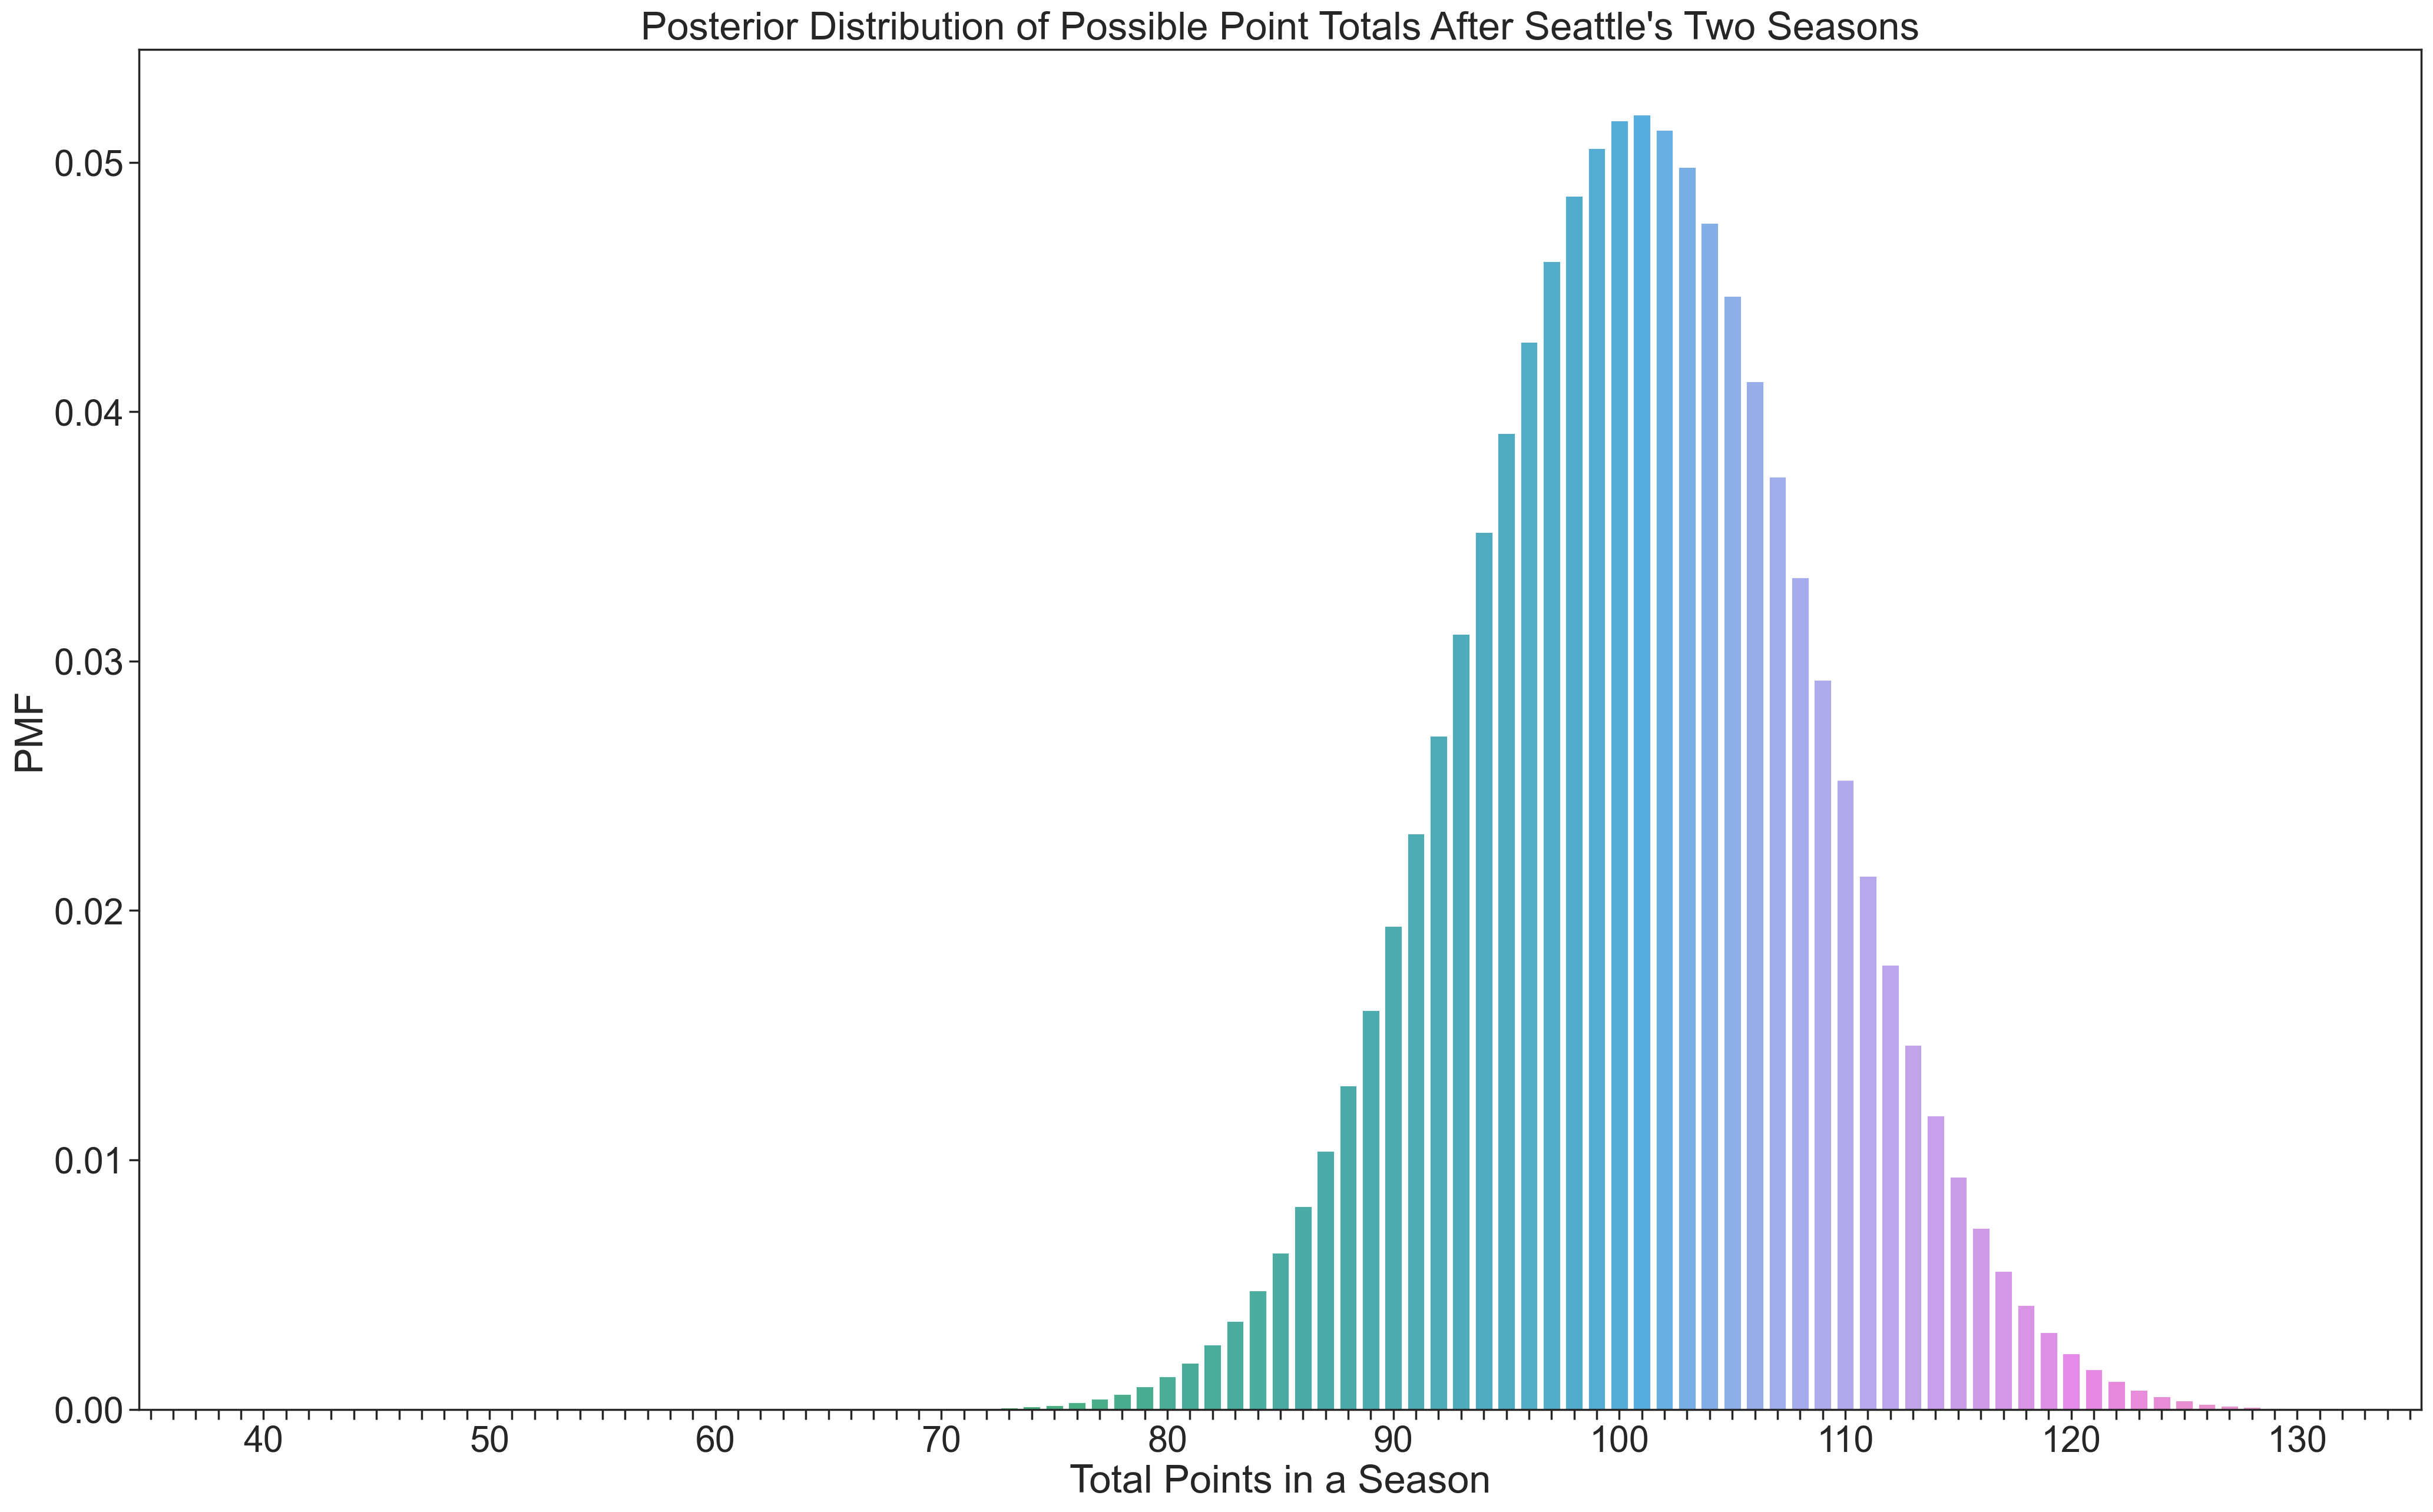

In [32]:
ax = sns.barplot(x=posterior.index, y=posterior)
for label in ax.get_xticklabels():
    if np.int64(label.get_text()) % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_xlabel("Total Points in a Season")
ax.set_ylabel("PMF")
ax.set_title("Posterior Distribution of Possible Point Totals After Seattle's Two Seasons")
plt.show()

In [28]:
posterior.idxmax()

101

In [29]:
def quantile(pmf, prob):
    total = 0
    for (score, p) in pmf.items():
        total += p
        if total >= prob:
            return score
    return np.nan

In [30]:
quantile(posterior, 0.025)

86

In [31]:
quantile(posterior, 0.975)

116